<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

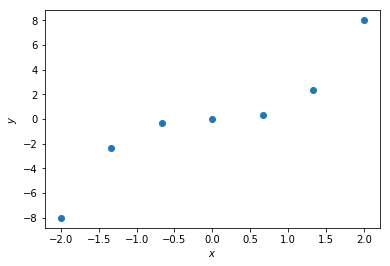

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

In [4]:
m_y=np.ones(7)*np.mean(y)

In [5]:
m_y

array([ -2.53765263e-16,  -2.53765263e-16,  -2.53765263e-16,
        -2.53765263e-16,  -2.53765263e-16,  -2.53765263e-16,
        -2.53765263e-16])

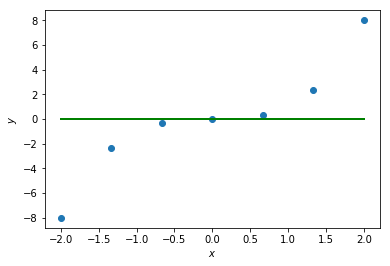

In [6]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X, m_y, "g", lw=2)

In [7]:
y

array([-8.        , -2.37037037, -0.2962963 ,  0.        ,  0.2962963 ,
        2.37037037,  8.        ])

In [8]:
y[0:3]

array([-8.        , -2.37037037, -0.2962963 ])

In [9]:
y[3:7]

array([ 0.        ,  0.2962963 ,  2.37037037,  8.        ])

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [10]:
m_y2 = np.append(np.ones(3)*np.mean(y[0:3]), np.ones(4)*np.mean(y[3:7]))

In [11]:
m_y2

array([-3.55555556, -3.55555556, -3.55555556,  2.66666667,  2.66666667,
        2.66666667,  2.66666667])

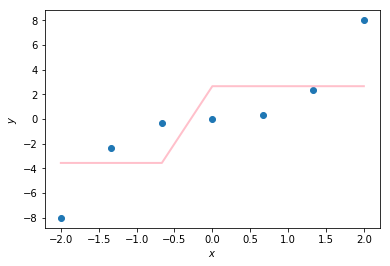

In [12]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X, m_y2, "pink", lw=2)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [13]:
def regression_var_criterion(X, y, t):
    pos = np.amax(np.where(X < t))+1
    X_l = X[:pos]
    X_r = X[pos:]
    y_l = y[:pos]
    y_r = y[pos:]
    return np.var(y) - (X_l.size/X.size)*np.var(y_l) - (X_r.size/X.size)*np.var(y_r)

In [14]:
X = np.linspace(-2, 2, 10)
y = X ** 3

In [15]:
X

array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
        0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ])

In [16]:
pos = np.amax(np.where(X < 1))+1

In [17]:
pos

7

In [18]:
X_1 = X[:pos]

In [19]:
X_1

array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
        0.22222222,  0.66666667])

In [20]:
X_2 = X[pos:]

In [21]:
X_2

array([ 1.11111111,  1.55555556,  2.        ])

In [22]:
np.var(y)

16.027547742835047

In [23]:
y.size

10

In [24]:
Q = regression_var_criterion(X=X, y=y, t=1.2)

In [25]:
Q

8.6495697546858441

In [26]:
t_in = np.arange(-1.9, 1.9, 0.1)
X_in = np.linspace(-2, 2, 10)
y_in = X ** 3

In [27]:
X_in

array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
        0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ])

In [28]:
Q=[]
for i in t_in:
    Q.append(regression_var_criterion(X=X_in, y=y_in, t=i))
   
    

In [29]:
Q_a = np.array(Q)

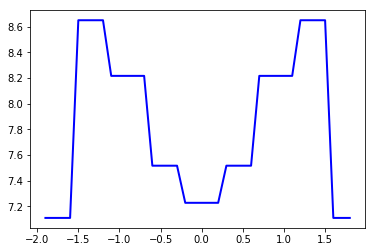

In [30]:
plt.plot(t_in, Q_a, "b", lw=2)

In [31]:
Q_a

array([ 7.11111111,  7.11111111,  7.11111111,  7.11111111,  8.64956975,
        8.64956975,  8.64956975,  8.64956975,  8.21663364,  8.21663364,
        8.21663364,  8.21663364,  8.21663364,  7.51755322,  7.51755322,
        7.51755322,  7.51755322,  7.22864815,  7.22864815,  7.22864815,
        7.22864815,  7.22864815,  7.51755322,  7.51755322,  7.51755322,
        7.51755322,  8.21663364,  8.21663364,  8.21663364,  8.21663364,
        8.21663364,  8.64956975,  8.64956975,  8.64956975,  8.64956975,
        7.11111111,  7.11111111,  7.11111111])

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет ответ

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [32]:
X = np.linspace(-2, 2, 10)
y = X ** 3

In [33]:
pos0=np.amax(np.where(X < 0))+1
pos1=np.amax(np.where(X<-1.5))+1
pos2=np.amax(np.where(X<1.5))+1

In [34]:
X[pos2:]

array([ 1.55555556,  2.        ])

In [56]:
y1=np.full((X[:pos1].size,1), np.mean(y[:pos1]))
y2=np.full((X[pos1:pos0].size,1), np.mean(y[pos1:pos0]))
y3=np.full((X[pos0:pos2].size,1), np.mean(y[pos0:pos2]))
y4=np.full((X[pos2:].size,1), np.mean(y[pos2:]))

In [61]:
y_m3=np.concatenate((y1,y2,y3,y4), axis=0)

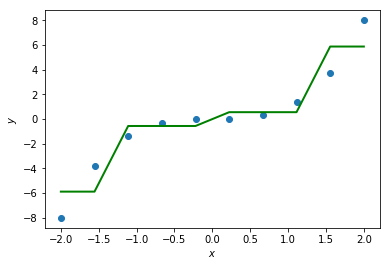

In [64]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X, y_m3, "green", lw=2)

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7 ответ
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [98]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [99]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [100]:
df['age_years']=df['age']/365.25

In [101]:
df=pd.concat([df, pd.get_dummies(df['cholesterol'], prefix='chol_d')], axis=1)

In [102]:
df=pd.concat([df, pd.get_dummies(df['gluc'], prefix='gluc_d')], axis=1)

In [106]:
y=df['cardio'].astype('int')
X=df.drop('cardio', axis=1)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [107]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [108]:
X_train.shape, X_valid.shape

((49000, 18), (21000, 18))

In [113]:
d_tree=DecisionTreeClassifier(random_state=17, max_depth=3)


In [115]:
d_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [122]:
from sklearn.tree import export_graphviz
export_graphviz(d_tree, out_file='cardio.dot', feature_names=X.columns, filled=True)
!dot -Tpng cardio.dot -o cardio.png

In [ ]:
<img src='cardio.png'>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3 ответ

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [127]:
tree_valid_pred = d_tree.predict(X_valid)
d_tree.score(X_valid, y_valid)

0.72128571428571431

In [128]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, tree_valid_pred)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [130]:
tree_cv = DecisionTreeClassifier(random_state=17)
from sklearn.model_selection import GridSearchCV
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree_cv, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [143]:
tree_grid.grid_scores_

/home/vmt/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71551, std: 0.00363, params: {'max_depth': 2},
 mean: 0.72771, std: 0.00485, params: {'max_depth': 3},
 mean: 0.73049, std: 0.00453, params: {'max_depth': 4},
 mean: 0.73096, std: 0.00523, params: {'max_depth': 5},
 mean: 0.73198, std: 0.00506, params: {'max_depth': 6},
 mean: 0.73047, std: 0.00352, params: {'max_depth': 7},
 mean: 0.72971, std: 0.00395, params: {'max_depth': 8},
 mean: 0.72790, std: 0.00477, params: {'max_depth': 9},
 mean: 0.72604, std: 0.00484, params: {'max_depth': 10}]

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [145]:
tree_grid.best_score_, tree_grid.best_params_

(0.73197959183673467, {'max_depth': 6})

In [146]:
tree_grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [147]:
tree_valid_pred2 = tree_grid.predict(X_valid)

In [148]:
tree_grid.score(X_valid, y_valid)

0.72585714285714287

In [149]:
(tree_grid.score(X_valid, y_valid)-d_tree.score(X_valid, y_valid))/d_tree.score(X_valid, y_valid)

0.0063378886908298506

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет ответ
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.) да
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.) да, наверху
- Возраст от 50 до 55 (лет) да
- Курит / не курит да
- Возраст от 60 до 65 (лет)

In [186]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [187]:
df['age_years']=df['age']/365.25
df['age_45_50']=((df['age_years'] >= 45) & (df['age_years'] < 50)).astype('int64')
df['age_50_55']=((df['age_years'] >= 50) & (df['age_years'] < 55)).astype('int64')
df['age_55_60']=((df['age_years'] >= 55) & (df['age_years'] < 60)).astype('int64')
df['age_60_65']=((df['age_years'] >= 60) & (df['age_years'] < 65)).astype('int64')
df['ap_hi_120_140']=((df['ap_hi'] >= 120) & (df['ap_hi'] < 140)).astype('int64')
df['ap_hi_140_160']=((df['ap_hi'] >= 140) & (df['ap_hi'] < 160)).astype('int64')
df['ap_hi_160_180']=((df['ap_hi'] >= 160) & (df['ap_hi'] < 180)).astype('int64')
df['male']=(df['gender']==2).astype('int64')

In [188]:
df=pd.concat([df, pd.get_dummies(df['cholesterol'], prefix='chol_d')], axis=1)

In [189]:
df.drop(['age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','alco', 'age_years','active'], axis=1, inplace=True)

In [190]:
df

,smoke,cardio,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,male,chol_d_1,chol_d_2,chol_d_3
id,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,0,1,0,0,1,0,0,1,0,0,0,0,1
2,0,1,0,1,0,0,1,0,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,1,0,0
4,0,0,1,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,1,0,0,0,0,1,0
9,0,0,0,0,0,1,1,0,0,0,0,0,1
12,0,1,0,0,0,1,1,0,0,1,0,0,1
13,0,0,1,0,0,0,0,0,0,0,1,0,0


In [191]:
y=df['cardio'].astype('int')
X=df.drop('cardio', axis=1)

In [193]:
X.shape

(70000, 12)

In [200]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

In [201]:
f_tree=DecisionTreeClassifier(random_state=17, max_depth=3)

In [202]:
f_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [203]:
export_graphviz(f_tree, out_file='cardio2.dot', feature_names=X.columns, filled=True)
!dot -Tpng cardio2.dot -o cardio2.png

<img src='cardio2.png'>